<a href="https://colab.research.google.com/github/wostook/fraud-detection/blob/master/Credit_Cards_Fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# h2o4gpu is GPU accelerated machine learning package, that allows to take advantage of GPU and essentially speed up computations
# Only run this cell when using Google Colab notebook, otherwise make sure to install package using e.g. anaconda promt
!pip install h2o4gpu 

     |████████████████████████████████| 346.3MB 34kB/s 
     |████████████████████████████████| 6.7MB 38.4MB/s 
     |████████████████████████████████| 460kB 38.9MB/s 
  Created wheel for psutil: filename=psutil-5.7.2-cp36-cp36m-linux_x86_64.whl size=279878 sha256=4411ff192fe6982636560658937ef68d8f6ca78df4fe8b433c2033ee9ffbc740
  Stored in directory: /root/.cache/pip/wheels/39/a0/f5/c4fa280463e29aea07797acb5312358fefb067c1f4f98e11b1
Successfully built psutil
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [ ]:
import h2o4gpu as sklearn 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
from time import time

from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold,RandomizedSearchCV,GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report, average_precision_score, precision_recall_curve,roc_curve
from sklearn.feature_selection import f_classif
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from xgboost import XGBClassifier

import warnings
warnings.simplefilter("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [ ]:
# Connect with google drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


<font size="5">Data import and quick look </font>

The datasets contains transactions made by credit cards in September 2013 by European cardholders. Dataset is labled, with binary class - fraudulent and non-fraudelent transactions.

In [ ]:
# Read the CSV file from google drive 
data = pd.read_csv('/content/drive/My Drive/app/creditcard.csv')

In [ ]:
# Basic data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
data.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,3.919560e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,5.688174e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-8.769071e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.782312e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,-1.552563e-15,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,2.010663e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-1.694249e-15,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,-1.927028e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-3.137024e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [ ]:
print('There are {} null values'.format(data.isnull().sum().sum()))

There are 0 null values


There are 492 fraud intances (0.17%)
There are 284315 non-fraud intances (99.83%)


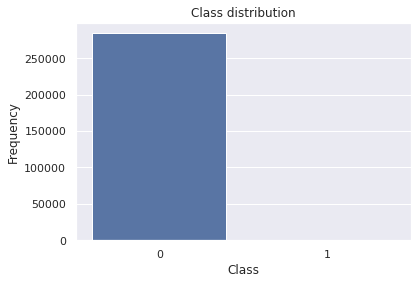

In [ ]:
# Plot number of fraud and legit records
counts=data['Class'].value_counts()
print('There are {} fraud intances ({:.2f}%)'.format(counts[1],(100*counts[1]/data.shape[0])))
print('There are {} non-fraud intances ({:.2f}%)'.format(counts[0],(100*counts[0]/data.shape[0])))
sns.countplot(data['Class'])
plt.title("Class distribution")
plt.xlabel("Class")
plt.ylabel("Frequency");

Few notes about data:
there are no missing values, there is no need to change data format
*   most of the features were anonymized
*   there are no missing values, there is no need to change data format
*   data is highly imbalanced, positive class accounts for 0.17% of transactions
*   features V1, V2, ... V28 are the principal components obtained with PCA
*   feature Class is target variable, it takes value 1 in case of fraud and 0 otherwise
*   Time and Amount were not transformed
*   the Time is the seconds between each transaction and the first transaction 
*   the Amount is the transaction amount 

Let's make some visualizations to get to know data better, starting with Time and Amount features.


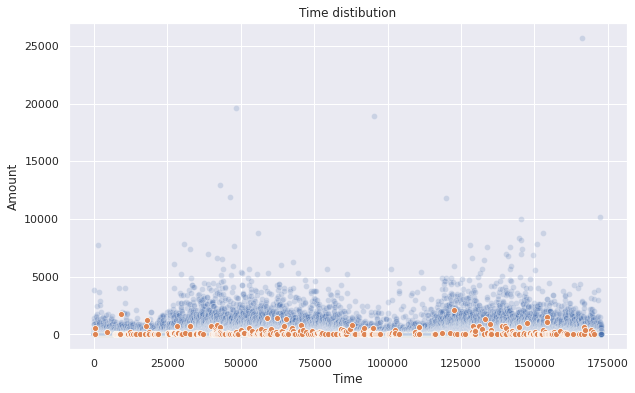

In [ ]:
fig,ax=plt.subplots(sharex=True,sharey=True,figsize=(10,6))
sns.scatterplot(data[data['Class']==0]['Time'],data[data['Class']==0]['Amount'],ax=ax,alpha=0.2)
sns.scatterplot(data[data['Class']==1]['Time'],data[data['Class']==1]['Amount'],ax=ax)
plt.xlabel('Time');
plt.title('Time distibution');

The fraudulent card transactions have much lower avarage Amount values. Time doesn't seem to be indicative.

<font size="5">Feature scaling </font>

To streamline further computations, one may need to scale Time and Amount features. The Amount contains some outliers, to take it into account, we will use Robust Scaler. The Time will be transformed using Standard Scaler.

In [ ]:
from sklearn.preprocessing import RobustScaler,StandardScaler
data['Amount_scaled'] = RobustScaler().fit_transform(data['Amount'].values.reshape(-1,1))
data['Time_scaled']=StandardScaler().fit_transform(data['Time'].values.reshape(-1,1))

data.drop(columns=['Amount','Time'],inplace=True)

<font size="5">ANOVA testing </font>

Analysis of variance is easy but powerfull statistical precedure that helps understand data better. Running ANOVA test provides user with get F and p-values, which tell about the differences among group means in a sample. It enables as us to compare how significantly similar/different feature distributions in a given class are.

In [ ]:
X=data.drop(columns='Class')
y=data['Class']
f,pval=f_classif(X,y)

In [ ]:
# assumed signifinace level is 0.05
anova=pd.DataFrame(pval,index=X.columns,columns=['pval'])
anova[anova['pval']>0.05]

,pval
V22,0.667360
V23,0.151860
V25,0.077525


For 3 features above, there is less than 5 % risk of concluding that a difference among distributons exists when there is no actual difference.
They don't seem to be good predictors, we might need to drop them later. 

Now we can plot distributions within each class, ordered with ascending p-value.

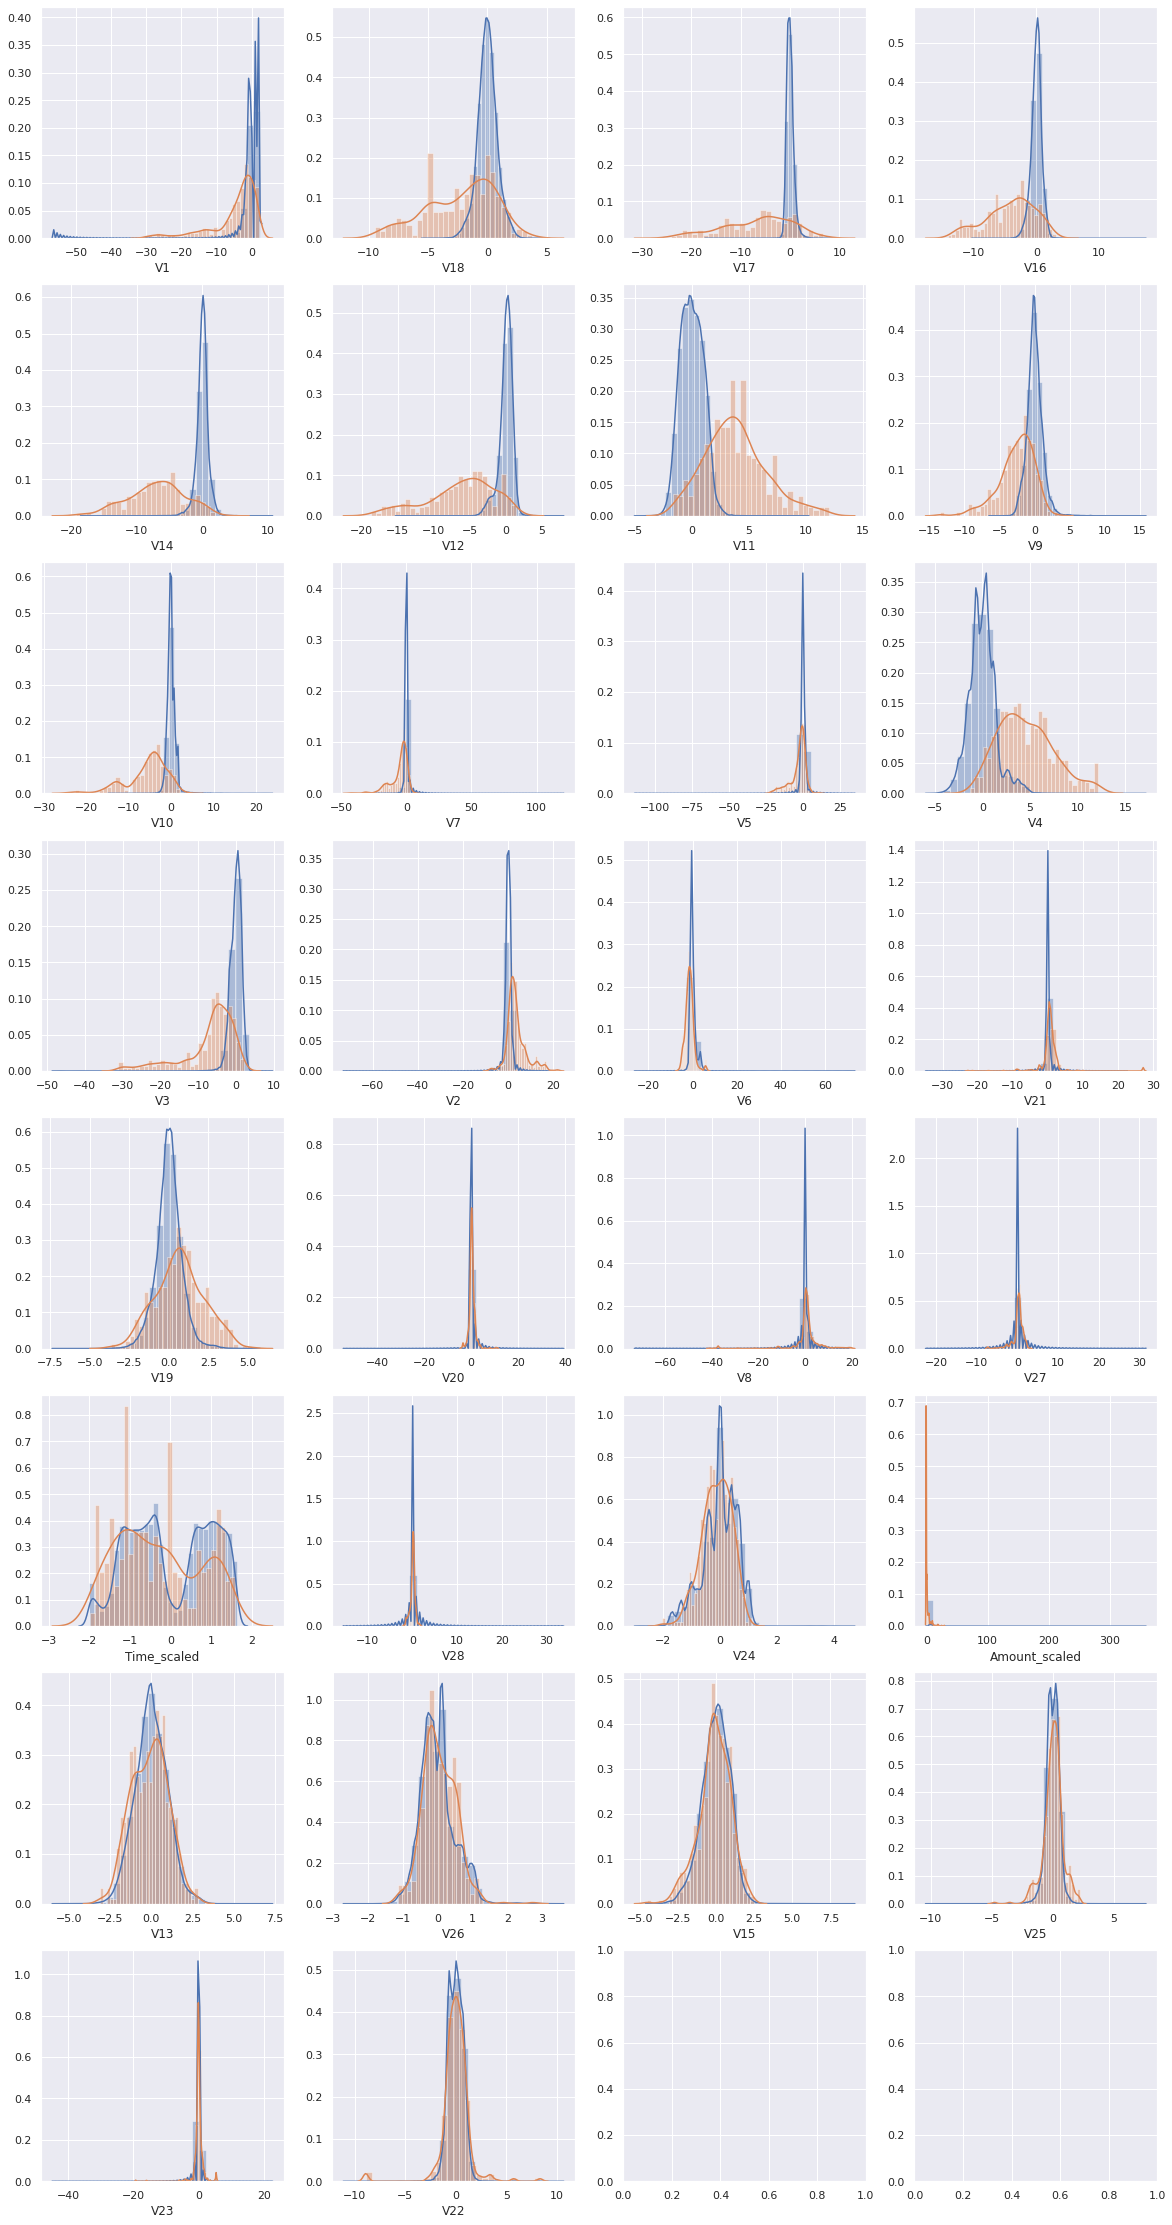

In [ ]:
# Features sorted by anova ascending p-values
ordered_indx=anova.sort_values(by='pval',ascending=True).index
fig, ax = plt.subplots(8, 4, figsize=(20, 40))
for variable, subplot in zip(ordered_indx, ax.flatten()):
    sns.distplot(data[data['Class']==0][variable],bins=30,ax=subplot)
    sns.distplot(data[data['Class']==1][variable],bins=30,ax=subplot)


Let's check correlations between features and target, and  for positive and negative class.

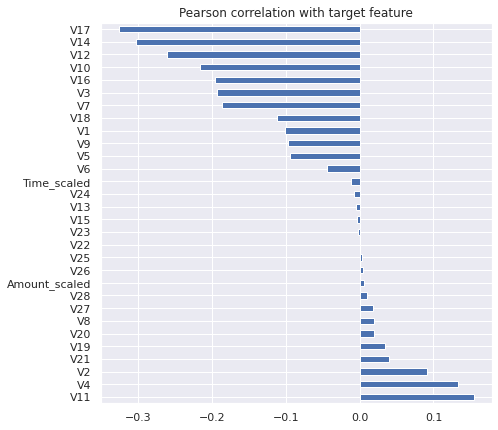

In [ ]:
# Simple correlation with between features and target, might be indicative; it is similar to Anova results
plt.figure(figsize=(7,7))
data.corr()['Class'].sort_values(ascending=False)[1:].plot.barh()
plt.title('Pearson correlation with target feature');

Heatmaps of correlations betweet features, in fraudelent and non-fraudelent class.

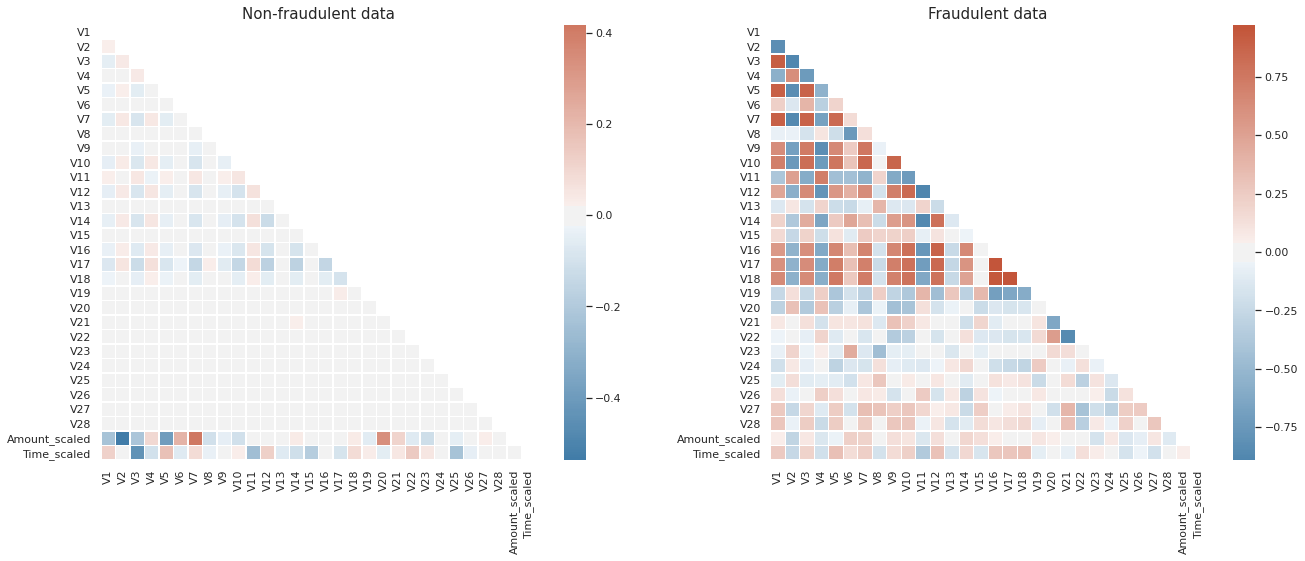

In [ ]:
# frauelent data
corFR=data[data['Class']==1].drop(columns='Class').corr()
# non-frauelent data
corNFR=data[data['Class']==0].drop(columns='Class').corr()
# setting palette and mask 
cmap = sns.diverging_palette(240,20, as_cmap=True)
mask = np.zeros_like(corFR)
mask[np.triu_indices_from(mask)] = True

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(22,8))
a=sns.heatmap(corNFR, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=0.15,ax=ax1)
a.set_facecolor('white')
a.set_title('Non-fraudulent data',fontsize=15)
b=sns.heatmap(corFR, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=0.15,ax=ax2)
b.set_facecolor('white')
b.set_title('Fraudulent data',fontsize=15);

Since PCA was run on most of the features beforehand, all anonymized features are not correlated within dominating non-fraudulent class. However, taking into account fradulent class, some strong correlations emerge. To take a look at up close, let's make series of scatterplots with most correlated features.  

In [ ]:
def get_correlated_plot(dataset,treshold=0.85):
  """ 
  Create scatterplot between most correlated features, taking into account 
  target class.
  --------------
  Parameters:
  dataset : dataframe 
  treshold : absolute value of Pearson correlation coefficient between variables

  Return : subplots of scatterplots
  
  """
  # calculate correlation and get mask to simplify loop calculations
  cor_raw=dataset.corr()
  cor_mask=cor_raw.where(np.triu(np.ones(cor_raw.shape)).astype(np.bool))
  # create empy list and fill it with tuples of correlated features (above set treshold)
  l=[]
  for idx in cor_mask.index.values:
      for col in cor_mask.columns.values:
          if (cor_mask.loc[idx,col]>treshold or cor_mask.loc[idx,col]<-treshold) and idx!=col:
              l.append((idx,col))
                
  # set cols and rows number
  ncols=4
  nrows=[len(l)//ncols if len(l)%ncols==0 else len(l)//ncols+1][0]
  # create fraud and non-fraud datasets
  fraud=data[data['Class']==1]
  nonfraud=data[data['Class']==0]

  # make subplots 
  fig, ax = plt.subplots(nrows, ncols, figsize=(15, 14))
  for variable, subplot in zip(l, ax.flatten()):
      sns.scatterplot(nonfraud[variable[0]],nonfraud[variable[1]],label='non-fraud',alpha=0.3,ax=subplot)
      sns.scatterplot(fraud[variable[0]],fraud[variable[1]],label='fraud',alpha=0.7,ax=subplot)
      plt.xlabel('Time');
      plt.tight_layout()

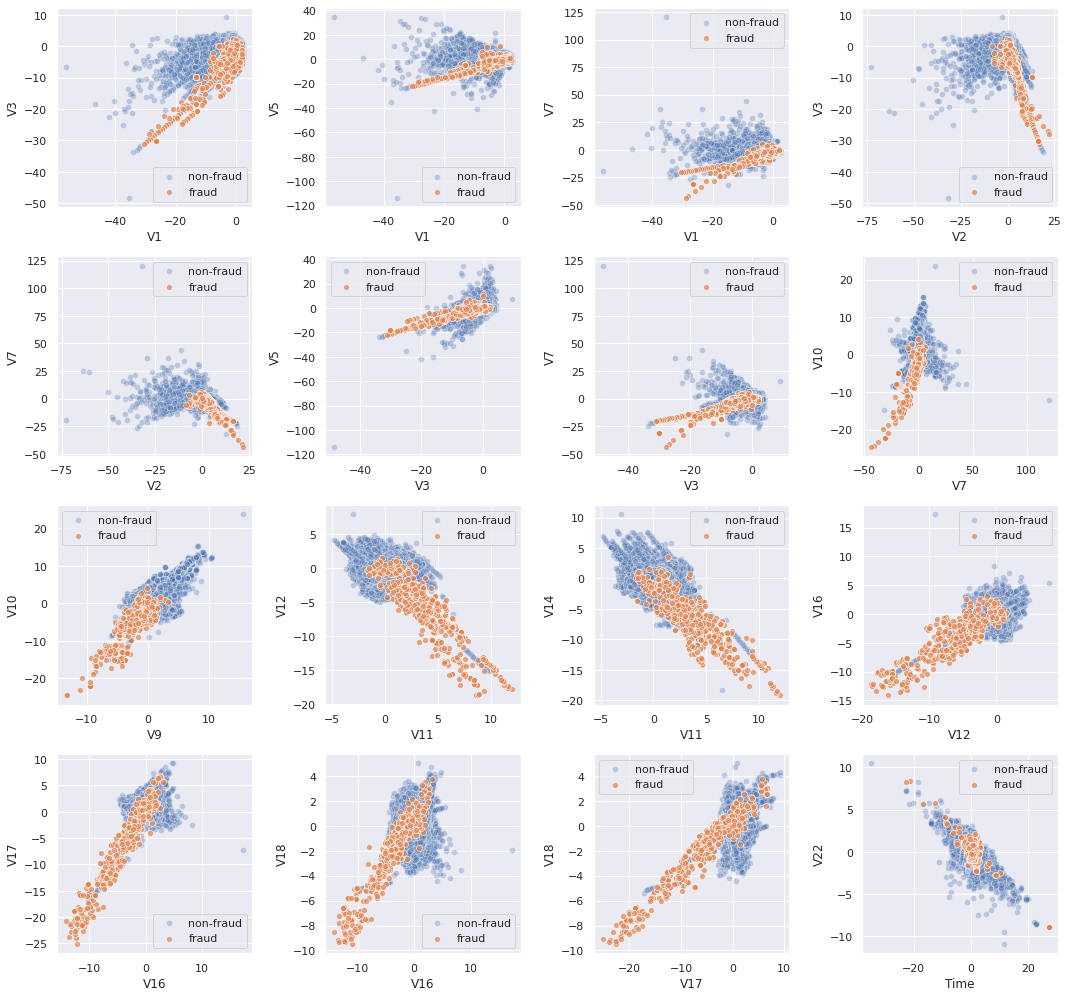

In [ ]:
get_correlated_plot(data[data['Class']==1],treshold=0.85)

Some features are visibily correlated in fraud class, they clearly exibit different distribution and behaviour, what make them potentially indicative.

<font size="5">Data spliting </font>

In [ ]:
# Since features V22, V23 and V25 seem to be not correlated with target, one should drop them
y=data['Class']
X=data.drop(columns=['Class','V22','V23','V25'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.2, random_state=1)

X_train=X_train.values
X_test=X_test.values
y_train=y_train.values
y_test=y_test.values

# Smote oversampling 
X_train_smote, y_train_smote = SMOTE(sampling_strategy='minority',random_state=0).fit_resample(X_train, y_train)

<font size="5">Metrics and quick look CV of selected models </font>

Because data is severely imbalanced and one aims to keep balance between recall and precision, averaged **F1 macro** score seems to be good metrics to optimize. It takes into account both recall and precision in both classes, averaged with weights proportional with class size. 

I decided to choose 3 predictors with different math and logic behind algorithms - **Logistic Regression, Random Forest Classifier and eXtreme Gradient Boosting Classifier**. Let's test them with 10-fold stratified cross validation, for raw and oversampled dataset.

In [ ]:
def cross_validated_f1(model,oversampling=False,scoring='f1_macro',n_splits=10):
  """
  Calculate cross validated F1 macro score (averaged for both traget classes)
  --------------
  Parameters:
  model : classifier  
  oversampling : Boolean value; oversample minority class
  scoring : classification metrics
  n_splits : number of folds
  --------------
  Return : print avaraged cross-validation score and standard deviation (for n-folds)

  """
  # Stratified K-Folds cross-validator
  cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=10)
  # when oversampled, make pipeline to avoid data leakage 
  if oversampling:
      imba_pipeline = make_pipeline(SMOTE(random_state=42), model)
      scores=cross_val_score(imba_pipeline, X_train, y_train, scoring='f1_macro', cv=cv)
  else:   
      scores=cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=cv)
  model_name=str(model).split('(')[0]
  print('Average CV F1 macro score of {}: {:.2f} +- {:.2f}'.format(model_name,np.mean(scores),np.std(scores)))

In [ ]:
# Models to check - Logistic Regression, Random Forest and XGBoost classifiers
models=[LogisticRegression(max_iter=600),RandomForestClassifier(random_state=1),XGBClassifier(random_state=1,tree_method='gpu_hist')]

print('WITHOUT OVERSAMPLING:\n')
for model in models:
  cross_validated_f1(model,oversampling=False)
print('\nWITH SMOTE OVERSAMPLING:\n')
for model in models:
  cross_validated_f1(model,oversampling=True)

WITHOUT OVERSAMPLING:

Average CV F1 macro score of LogisticRegression: 0.85 +- 0.03
Average CV F1 macro score of RandomForestClassifier: 0.91 +- 0.03
Average CV F1 macro score of XGBClassifier: 0.93 +- 0.02

WITH SMOTE OVERSAMPLING:

Average CV F1 macro score of LogisticRegression: 0.55 +- 0.00
Average CV F1 macro score of RandomForestClassifier: 0.92 +- 0.02
Average CV F1 macro score of XGBClassifier: 0.89 +- 0.02


Oversampling doesn't seem to significantly improve raw model performances.There is a slight improvement in models' bias (decrease in standard deviation), however it was already low for unsampled data. The significant drop of F1 is observed for Logisitic Regression, and a small drop for XGBoost.

Let's analyse now classification reports for test data.

In [ ]:
# Print classification report for each raw model (X_test,y_test datasets), without fraud class oversampling

models=[LogisticRegression(max_iter=600),RandomForestClassifier(random_state=1),XGBClassifier(random_state=1,tree_method='gpu_hist')]

for model in models:
  model.fit(X_train,y_train)
  model_name=str(model).split('(')[0]
  print('{} classification report:\n'.format(model_name))
  print(classification_report(y_test,model.predict(X_test)))
  print('---'*20)

LogisticRegression classification report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.69      0.78        98

    accuracy                           1.00     56962
   macro avg       0.94      0.85      0.89     56962
weighted avg       1.00      1.00      1.00     56962

------------------------------------------------------------
RandomForestClassifier classification report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.85      0.89        98

    accuracy                           1.00     56962
   macro avg       0.97      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962

------------------------------------------------------------
XGBClassifier classification report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.

In [ ]:
# Print classification report for each raw model (X_test,y_test datasets), with fraud class oversampling (SMOTE)
for model in models:
  model.fit(X_train_smote,y_train_smote)
  model_name=str(model).split('(')[0]
  print('Oversampled {} classification report:\n'.format(model_name))
  print(classification_report(y_test,model.predict(X_test)))
  print('---'*20)

Oversampled LogisticRegression classification report:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962

------------------------------------------------------------
Oversampled RandomForestClassifier classification report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.86      0.85        98

    accuracy                           1.00     56962
   macro avg       0.92      0.93      0.93     56962
weighted avg       1.00      1.00      1.00     56962

------------------------------------------------------------
Oversampled XGBClassifier classification report:

              precision    recall  f1-score   support

     

Since oversampling doesn't impact model performance in an expected way and bigger datasets make all models more computationally expensive, raw unsampled data will be used for futher grid search on hyper parameters.

<font size="5">Hyperparameters tuning</font>

In [ ]:
def get_optimal_model(model,params,
                      search_type='random',
                      n_splits=5,
                      n_iter=5,
                      scoring='f1_macro'):
  
  """
  Calculate model with different set of parameters and choose the best, based on set metrics.
  The parameters of the estimator used are optimized by cross-validated search over parameter settings.
  --------------
  Parameters:
  model : classifier  
  type : 'random' - randomized grid search on hyper parameters
         'full' - normal grid search 'full'
  n_splits : number of folds
  n_iter : number of parameter settings that are sampled
  scoring : classification metric
  --------------
  Return : model with best set of parameters 
  """
  # Cross validator - it preserves class balance in each fold 
  cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=3)
  
  # Grid search type
  if search_type=='full':
    grid_search = GridSearchCV(model,params, 
                                  scoring=scoring,
                                  refit=True, 
                                  cv=cv,
                                  verbose=1,
                                  n_jobs=-1)
  else:
    grid_search = RandomizedSearchCV(model, 
                                  params, 
                                  scoring=scoring,
                                  random_state= 10,
                                  refit=True, 
                                  cv=cv,
                                  n_iter=n_iter,
                                  verbose=1,
                                  n_jobs=-1)

  start = time() # start time
  model_fit = grid_search.fit(X_train, y_train)
  model_best = grid_search.best_estimator_
  end = time() # end time
  print('---'*20)
  print('Elapsed time: {0:.2f} s\n'.format(end-start))
  print('Best model: {}\n'.format(model_best))
  print('Best F1 macro averaged score: {:.3f}'.format(model_fit.best_score_))
  print('---'*20)
  print('Running 10-fold cross-validation...\n')
  cross_validated_f1(model) # get 10-fold cross validated score on train data
  print('---'*20)
  print('Training best model...')
  start=time() 
  model_best.fit(X_train,y_train) # model with best performance parameters
  end=time() 
  print('Elapsed time: {0:.2f} s\n'.format(end-start))
  print('Classification report for test data')
  print(classification_report(y_test, model_best.predict(X_test)))
  return model_best

<font size="5">Logistic Regression grid search</font>

In [ ]:
model=LogisticRegression(max_iter=600)
params = {"penalty": ['l1', 'l2'], 'C': [0.1, 1, 10, 100],'class_weight':['balanced',None]}
lr=get_optimal_model(model,params,search_type='full')

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  5.2min finished


------------------------------------------------------------
Elapsed time: 324.79 s

Best model: LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=600,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Best F1 macro averaged score: 0.850
------------------------------------------------------------
Running 10-fold cross-validation...

Average CV F1 macro score of LogisticRegression: 0.85 +- 0.03
------------------------------------------------------------
Training best model...
Elapsed time: 8.99 s

Classification report for test data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.69      0.77        98

    accuracy                           1.00     56962
   macro avg       0.9

<font size="5">Random Forest Clasiffier grid search</font>

In [ ]:
model=RandomForestClassifier(random_state=1,max_leaf_nodes=100)
#since RF grid search is very slow, only two parameters will be optimized
params={'max_depth': [3,5,7],
 'n_estimators': [50,100,200,500]}

rfc=get_optimal_model(model,params,search_type='full')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 46.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 80.2min finished


------------------------------------------------------------
Elapsed time: 4855.42 s

Best model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

Best F1 macro averaged score: 0.919
------------------------------------------------------------
Running 10-fold cross-validation...

Average CV F1 macro score of RandomForestClassifier: 0.92 +- 0.03
------------------------------------------------------------
Training best model...
Elapsed time: 43.23 s

Classification report for test data
              precision    recall  f1-score   support

           0       1

<font size="5">XGBClassifier randomized grid search</font>

In [ ]:
model=XGBClassifier(random_state=1,tree_method='gpu_hist')
params =    {
            'max_depth': [3, 4, 5],
            'learning_rate': [0.1, 0.2, 0.3, 0.5],
            'n_estimators': [50, 100, 150,300,500,700],
            'gamma': [0, 0.5, 1, 1.5, 2, 5],
            'min_child_weight': [0, 0.5, 1, 5, 10],
            'max_delta_step': [0],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1],
            'colsample_bylevel': [1],
            'reg_alpha': [0, 1e-2, 1, 1e1],
            'reg_lambda': [0, 1e-2, 1, 1e1],
            'base_score': [0.5],
            'scale_pos_weight': [1,578] 
            }

# because model is optimized for GPU calculations, we might afford more extensive search, increasing number of iterations
xgboost=get_optimal_model(model,params,search_type='random',n_iter=250)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 54.7min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 87.7min
[Parallel(n_jobs=-1)]: Done 1250 out of 1250 | elapsed: 87.9min finished


------------------------------------------------------------
Elapsed time: 5285.42 s

Best model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=0, missing=nan,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=1, reg_alpha=0.01,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

Best F1 macro averaged score: 0.935
------------------------------------------------------------
Running 10-fold cross-validation...

Average CV F1 macro score of XGBClassifier: 0.93 +- 0.02
-----------------

<font size="5">Model visualization and interpretation</font>

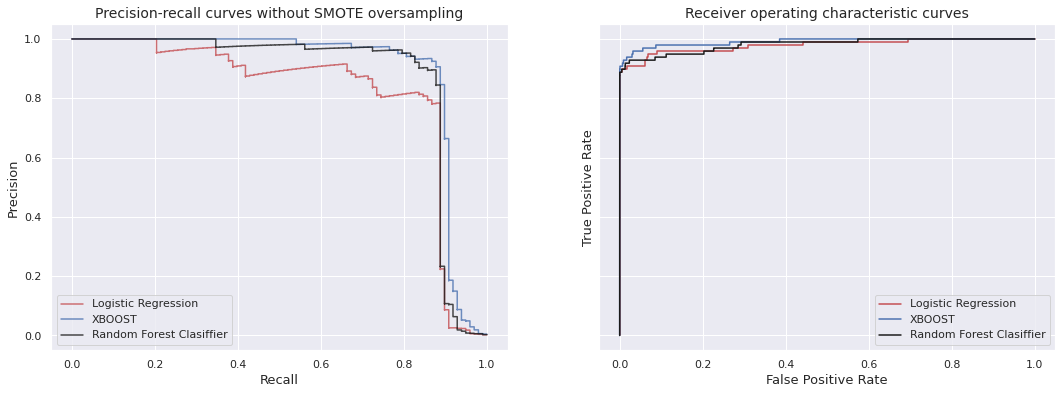

In [28]:
# models list - for imbalanced and oversampled datasets
models=[lr,xgboost,rfc]

# colors list
colors=['r','b','k']
# models dictionary
d={lr:'Logistic Regression',
  xgboost:'XBOOST',
     rfc:'Random Forest Clasiffier'}
# make subplots with precision-recall curves 
fig,axes=plt.subplots(1,2,sharex=True,sharey=True,figsize=(18,6))
for i,model in enumerate(models):
    color=colors[i]
    y_score_= model.predict_proba(X_test)[:,-1]
    precision, recall,rc_thresholds  = precision_recall_curve(y_test, y_score_)

    axes[0].step(recall, precision, color=color, alpha=0.8,
         where='post',label=d[model])
    axes[0].legend()
axes[0].set_title('Precision-recall curves without SMOTE oversampling', size=14) # Title
axes[0].set_ylabel('Precision',size=13)
axes[0].set_xlabel('Recall',size=13)

# make subplots with ROC curves
for i,model in enumerate(models):
    color=colors[i]
    y_score_= model.predict_proba(X_test)[:,-1]
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_score_)
    axes[1].step(fpr, tpr, label=d[model],color=color)
    axes[1].legend()
axes[1].set_title('Receiver operating characteristic curves', size=14) # Title
axes[1].set_ylabel('True Positive Rate',size=13)
axes[1].set_xlabel('False Positive Rate',size=13);

Precision - recall curve is most indicative for imbalanced datasets. It shows possible range of precision-recall values that one might achieve by changing threshold on decision function. Depending on bussiness objective, optimal values for recall and precision might be determined. Increasing recall means decreasing in precision. It's a question of compromise and sometimes small tweaks in thershold level are enough to reach it. 

ROC curve is also quite powerfull tool, however it's insensitive to class imbalance and can be overly optimistic. It's clearly visible in a plot above, where it's actually hard to tell the difference in models' perfomance. Interpretation might be very misleading and simply wrong. 

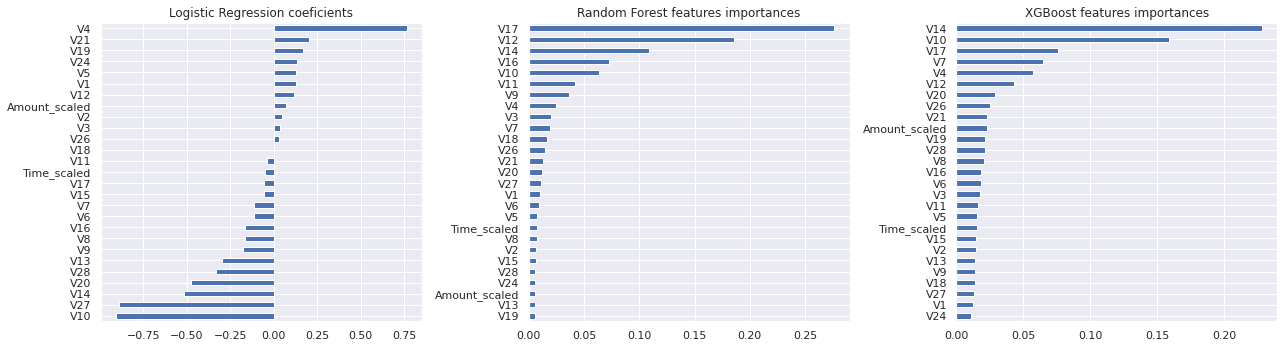

In [30]:
# feature importance and coefficients 
features=[lr.coef_[0],rfc.feature_importances_,xgboost.feature_importances_]
fig,axes = plt.subplots(1,3,figsize=(18,5))
for i in range(len(features)):
  pd.DataFrame(features[i],index=X.columns,columns=['feature']).sort_values(by='feature').plot(kind='barh',ax=axes[i])
  axes[i].get_legend().remove()
axes[0].set_title('Logistic Regression coeficients')
axes[1].set_title('Random Forest features importances')
axes[2].set_title('XGBoost features importances')
plt.tight_layout()

One of the ways to interpret model results, is to check coefficient values (Logistic Regression) or relative features importanaces (RF and XGBoost). 

**Logistic Regression**

The top 5 features that have the biggest impact on predicted values are V10,V27,V4,V14 and V20. Apart from V4, all of them are negatively correlated with positive class. How to interpret coefficient values ? Each coeff value shows how LOG of the odds ratio changes with a unit increase in the exponatory variable. For example- for a one-unit increase in the V10 coefficient (-0.91), we will see 60% decrease in the odds of being classified as non-fraudulent (positive class), since exp(-0.91) = 0.4.

**Random Forest**

The top 5 most important features are 17,12,14,16 and 10. The feature ranking is calculated as the decrease in node impurity, weighted by the probability of reaching that node.The higher the value the more important the feature.

**XGBoost**

The most important features are 14 and 10, the rest have similar importance. Feature importance is calculated in a analogical way to RF case.  


**Final choice and recommendation**

Taking into account overall model performance, the best choice is XGBoost. It's very stable, generalize well, showing very low variance and low bias. What's also very important - thanks to optimized gpu computing- it's really fast to train and run. Random Forest shows similar performance, but it's way slower. Logistic Regression is relatively quick, but visibly underperforms other models.

**Lessons learned**



*   It's possible to build good-performance model despite class imbalance
*   Oversampling doesn't have to impact model performance (Random Forest and XGBost), adding unnecessary computational load
*   Oversampling might decrease Logistic Regression performance, boosting recall at precision's expense
*   XGBoost proved to be most efficent (at least when using GPU-optimized implementation); it performs well and is time efficient
*   Precision-recall plot is easy way to compare models and chose right threshold on decision function
*   ROC plot might be misleading and shouldn't be used for imbalanced datasets
*   Changing threshold on model's decision function, one might adjust model's performance, balancing out recall and precision
*   Model performance depends on data representation and model logic, different algorithms might give features totally different importance
*   GPU optimized implementation might significantly reduce computation time  


